In [7]:
# Deep Learning 101 for Scientists and Engineers
# Chapter 4.2 Transformer Architecture and Key Components
# Yong-Jun Shin, 2024

# Positional Encoding

import numpy as np

# Example embeddings
embeddings = np.array([[0.2, 0.5], [0.8, 0.5], [0.9, 0.6]])
positions = np.array([0, 1, 2])
d_model = 2  # Dimension of the embeddings

# Generate positional encodings
positional_encodings = np.zeros_like(embeddings)
for pos in range(len(positions)):
    for i in range(d_model):
        # Calculate the argument for the sin and cos functions
        position_factor = positions[pos] / (10000 ** ((2 * i) / d_model))
        if i % 2 == 0:
            positional_encodings[pos, i] = np.sin(position_factor)
        else:
            positional_encodings[pos, i] = np.cos(position_factor)

# Combine embeddings with positional encodings
modified_embeddings = embeddings + positional_encodings

print("Original Embeddings:\n", embeddings)
print("Positional Encodings:\n", positional_encodings)
print("Modified Embeddings:\n", modified_embeddings)



Original Embeddings:
 [[0.2 0.5]
 [0.8 0.5]
 [0.9 0.6]]
Positional Encodings:
 [[0.         1.        ]
 [0.84147098 1.        ]
 [0.90929743 0.99999998]]
Modified Embeddings:
 [[0.2        1.5       ]
 [1.64147098 1.5       ]
 [1.80929743 1.59999998]]


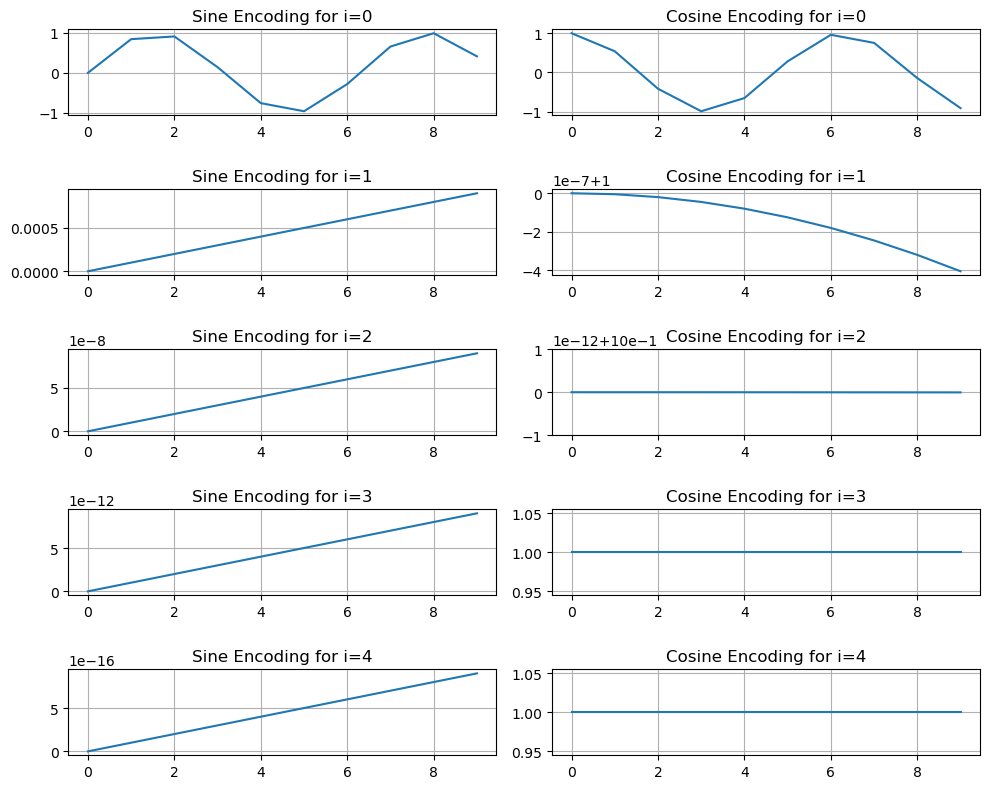

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(positions, d_model, i):
    """
    Calculates positional encoding for a given dimension 'i' and a range of positions.
    """
    # Calculate angle rates
    angle_rates = 1 / np.power(10000, (2 * i / np.float32(d_model)))
    
    # Calculate angles
    angles = positions * angle_rates
    
    # Sine and cosine calculations
    sine = np.sin(angles)
    cosine = np.cos(angles)
    
    return sine, cosine

def plot_positional_encodings(d_model, max_i, positions):
    """
    Plots the positional encodings for different 'i' values in the model.
    """
    plt.figure(figsize=(10, 8))
    for i in range(max_i):
        sine, cosine = positional_encoding(positions, d_model, i)
        plt.subplot(max_i, 2, 2*i + 1)
        plt.plot(positions, sine)
        plt.title(f'Sine Encoding for i={i}')
        plt.grid(True)

        plt.subplot(max_i, 2, 2*i + 2)
        plt.plot(positions, cosine)
        plt.title(f'Cosine Encoding for i={i}')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Model dimensionality and range of positions
d_model = 2
positions = np.arange(0, 10)
max_i = 5  # Adjust to visualize more dimensions

# Plot the positional encodings
plot_positional_encodings(d_model, max_i, positions)


In [31]:
import numpy as np

def layer_normalization(inputs, epsilon=1e-7):
    """Apply layer normalization on each input embedding independently."""
    mean = np.mean(inputs, axis=1, keepdims=True)
    std = np.std(inputs, axis=1, keepdims=True)
    normalized = (inputs - mean) / (std + epsilon)
    return normalized

# Generate random data with 3 embeddings, each of dimension 3
data = np.random.uniform(0, 1, (3, 3))

# Apply layer normalization
normalized_data = layer_normalization(data)

# Print results with 3 decimal places
np.set_printoptions(precision=3)
print("Original Data:\n", data)
print("Normalized Data:\n", normalized_data)


Original Data:
 [[0.383 0.792 0.529]
 [0.568 0.926 0.071]
 [0.087 0.02  0.833]]
Normalized Data:
 [[-1.092  1.324 -0.232]
 [ 0.133  1.153 -1.286]
 [-0.614 -0.796  1.41 ]]


In [29]:
import numpy as np

def layer_normalization(inputs, epsilon=1e-7):
    """Apply layer normalization on each input vector independently."""
    mean = np.mean(inputs, axis=1, keepdims=True)
    std = np.std(inputs, axis=1, keepdims=True)
    normalized = (inputs - mean) / (std + epsilon)
    return normalized

# Generate random input data with 3 vectors, each of dimension 3
np.random.seed(0)  # Seed for reproducibility
data = np.random.uniform(0, 1, (3, 3))

# Apply layer normalization
normalized_data = layer_normalization(data)

# Calculate mean and std of normalized data
normalized_mean = np.mean(normalized_data, axis=1)
normalized_std = np.std(normalized_data, axis=1)

# Print results with 3 decimal places
np.set_printoptions(precision=3)
print("Original Data:\n", data)
print("Normalized Data:\n", normalized_data)
print("Mean of Normalized Data:\n", normalized_mean)
print("Standard Deviation of Normalized Data:\n", normalized_std)


Original Data:
 [[0.549 0.715 0.603]
 [0.545 0.424 0.646]
 [0.438 0.892 0.964]]
Normalized Data:
 [[-1.06   1.341 -0.281]
 [ 0.074 -1.26   1.186]
 [-1.403  0.547  0.856]]
Mean of Normalized Data:
 [-1.647e-15 -3.701e-16 -4.811e-16]
Standard Deviation of Normalized Data:
 [1. 1. 1.]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention (masked)
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                                 key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        # Encoder-decoder attention
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                      key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        # Feed-forward network
        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

# Example usage
d_model = 512
nhead = 8
num_decoder_layers = 6
dim_feedforward = 2048
dropout = 0.1

decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)

# Example input sequences
src_len = 10  # Length of input sequence to the encoder
tgt_len = 20  # Length of output sequence to the decoder
batch_size = 32  # Batch size

# Random input sequences with matching embedding dimensions
memory = torch.rand((src_len, batch_size, d_model))  # Encoder output (memory)
tgt = torch.rand((tgt_len, batch_size, d_model))  # Target sequence

# Generate a subsequent mask for the target sequence
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    return mask

tgt_mask = generate_square_subsequent_mask(tgt_len)

# Forward pass through the Transformer decoder
output = transformer_decoder(tgt, memory, tgt_mask=tgt_mask)

print(output.shape)  # Output shape: (tgt_sequence_length, batch_size, d_model)


In [33]:
import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'
model = GPT2Model.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Define a simple linear layer for regression
class GPT2ForRegression(nn.Module):
    def __init__(self, gpt2_model):
        super(GPT2ForRegression, self).__init__()
        self.gpt2 = gpt2_model
        self.regressor = nn.Linear(self.gpt2.config.n_embd, 1)  # Output a single continuous value

    def forward(self, input_ids):
        outputs = self.gpt2(input_ids)
        hidden_states = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_states[:, -1, :]  # Use the representation of the last token
        regression_output = self.regressor(pooled_output)
        return regression_output

# Instantiate the regression model
regression_model = GPT2ForRegression(model)

# Example input data (a sequence of numbers)
input_data = "1.0 2.0 3.0 4.0 5.0"
inputs = tokenizer(input_data, return_tensors='pt')

# Perform a forward pass
output = regression_model(inputs.input_ids)

print("Regression output:", output)


Regression output: tensor([[-3.9653]], grad_fn=<AddmmBackward0>)
